<a href="https://colab.research.google.com/github/KumudaBG/Deep-Learning-Assignment6/blob/main/partB_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

##Import data from Kaggle

In [3]:
import json
kaggle_json = {"username":"kumudabg","key":"1134be2d95490124194bf94fac598ce7"}

In [4]:
import io,os
os.makedirs('/content/.kaggle/',exist_ok=True)
os.makedirs('/root/.kaggle/',exist_ok=True)

In [5]:
with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(kaggle_json, file)

In [6]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download -d aman2000jaiswal/agriculture-crop-images

 79% 47.0M/59.7M [00:00<00:00, 115MB/s] 
100% 59.7M/59.7M [00:00<00:00, 150MB/s]


In [8]:
! unzip agriculture-crop-images.zip -d agriculture-crop-images

Archive:  agriculture-crop-images.zip
  inflating: agriculture-crop-images/Crop_details.csv  
  inflating: agriculture-crop-images/crop_images/jute/jute001a.jpeg  
  inflating: agriculture-crop-images/crop_images/jute/jute002a.jpeg  
  inflating: agriculture-crop-images/crop_images/jute/jute003a.jpeg  
  inflating: agriculture-crop-images/crop_images/jute/jute004a.jpeg  
  inflating: agriculture-crop-images/crop_images/jute/jute005a.jpeg  
  inflating: agriculture-crop-images/crop_images/jute/jute006a.jpeg  
  inflating: agriculture-crop-images/crop_images/jute/jute007a.jpeg  
  inflating: agriculture-crop-images/crop_images/jute/jute008a.jpeg  
  inflating: agriculture-crop-images/crop_images/jute/jute009a.jpeg  
  inflating: agriculture-crop-images/crop_images/jute/jute010a.jpeg  
  inflating: agriculture-crop-images/crop_images/jute/jute011a.jpeg  
  inflating: agriculture-crop-images/crop_images/jute/jute012a.jpeg  
  inflating: agriculture-crop-images/crop_images/jute/jute013a.jpe

In [9]:
#folders inside "agriculture-crop-images"
!ls agriculture-crop-images

Crop_details.csv  crop_images  kag2  some_more_images  test_crop_image


##Filter out corrupted images

In [10]:
import os

num_skipped = 0
for folder_name in ("crop_images/jute","crop_images/maize","crop_images/rice","crop_images/sugarcane","crop_images/wheat", "test_crop_image"):
    folder_path = os.path.join("/content/agriculture-crop-images/", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 3 images


##Generate a Dataset

In [11]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/agriculture-crop-images/crop_images",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/agriculture-crop-images/crop_images",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 201 files belonging to 5 classes.
Using 161 files for training.
Found 201 files belonging to 5 classes.
Using 40 files for validation.


##Visualize Data

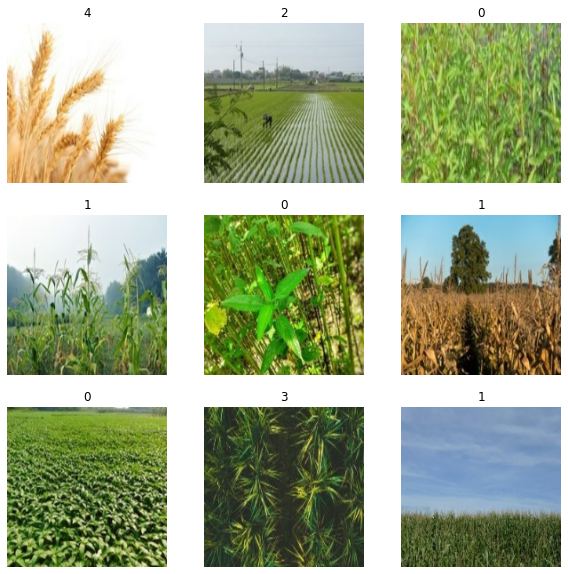

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


##Image data augmentation

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


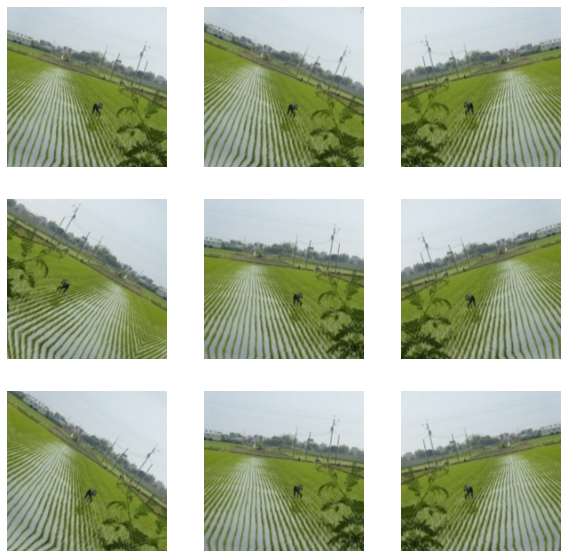

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(6):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

##Configure the dataset for performance

In [19]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

##Build Model

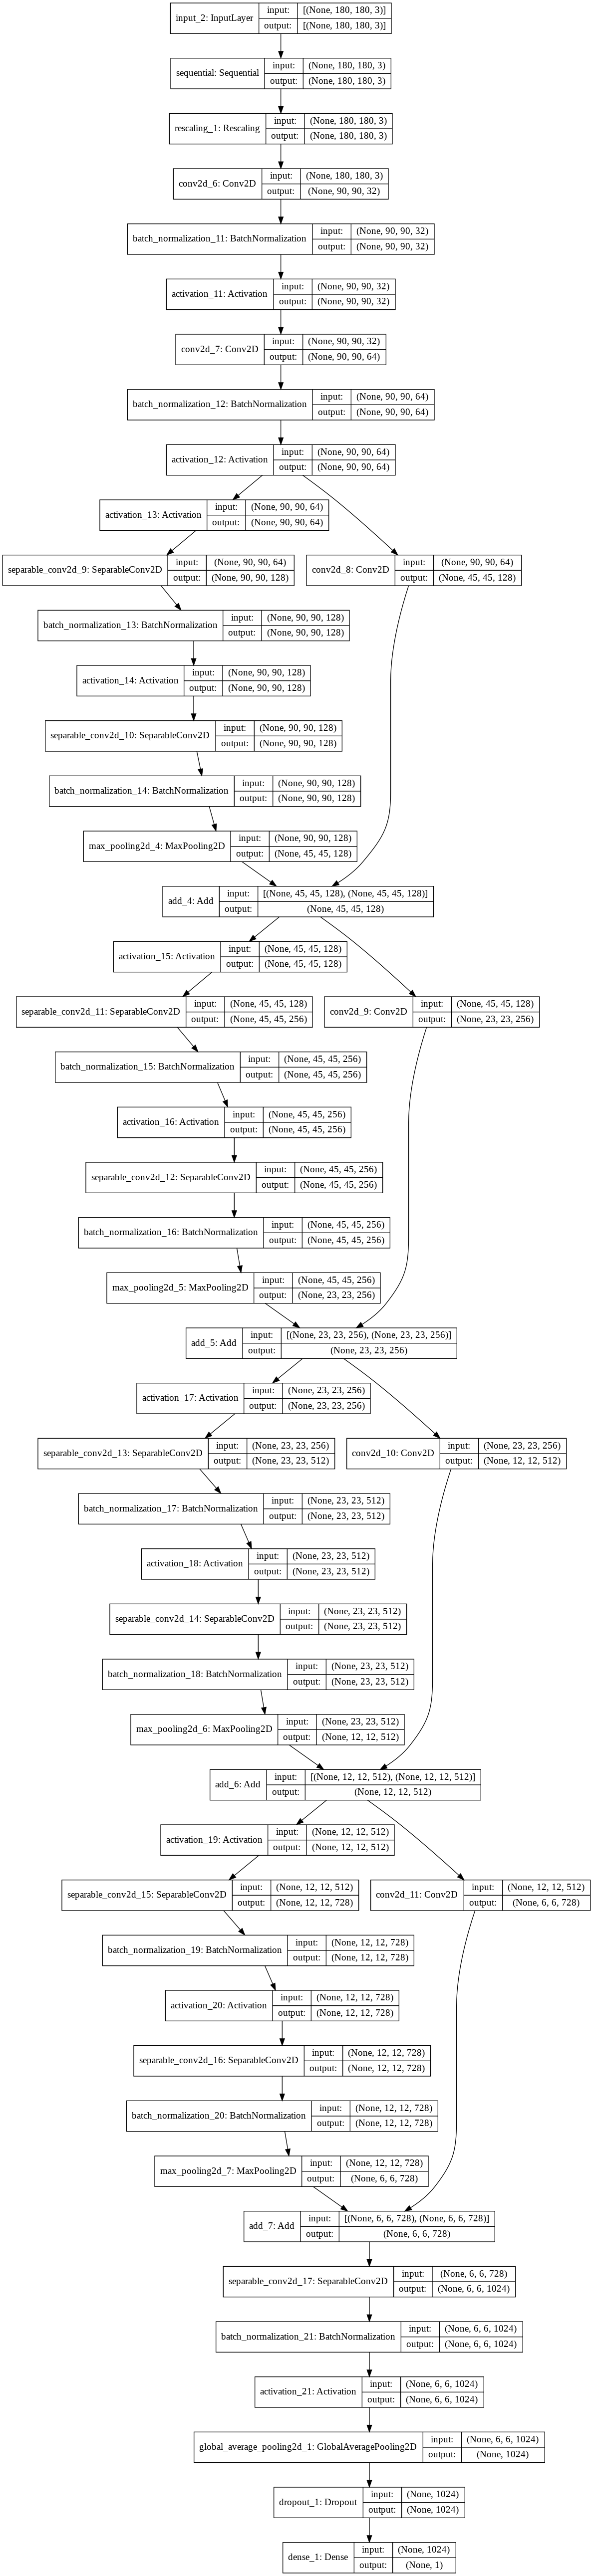

In [23]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 5:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=5)
keras.utils.plot_model(model, show_shapes=True)

##Train the model

In [41]:
epochs = 10

checkpoint = [
    keras.callbacks.ModelCheckpoint("save_at_50.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=checkpoint, validation_data=val_ds,
)

Epoch 1/10
6/6 [==============================] - 46s 7s/step - loss: -178.8321 - accuracy: 0.2346 - val_loss: -17.5397 - val_accuracy: 0.1750
Epoch 2/10
6/6 [==============================] - 43s 7s/step - loss: -184.9416 - accuracy: 0.2019 - val_loss: -10.1219 - val_accuracy: 0.1750
Epoch 3/10
6/6 [==============================] - 43s 7s/step - loss: -214.2485 - accuracy: 0.1732 - val_loss: -14.5621 - val_accuracy: 0.1750
Epoch 4/10
6/6 [==============================] - 43s 7s/step - loss: -209.1034 - accuracy: 0.1881 - val_loss: -18.5945 - val_accuracy: 0.1750
Epoch 5/10
6/6 [==============================] - 43s 7s/step - loss: -225.1457 - accuracy: 0.2223 - val_loss: -17.2358 - val_accuracy: 0.1750
Epoch 6/10
6/6 [==============================] - 43s 7s/step - loss: -216.9697 - accuracy: 0.1874 - val_loss: -31.7727 - val_accuracy: 0.1750
Epoch 7/10
6/6 [==============================] - 43s 7s/step - loss: -235.5551 - accuracy: 0.2004 - val_loss: -40.8848 - val_accuracy: 0.1750

In [42]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 180, 180, 3)  0           sequential[1][0]                 
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 90, 90, 32)   896         rescaling_1[0][0]                
____________________________________________________________________________________________

##Run inference on new data

In [45]:
img = keras.preprocessing.image.load_img(
    "/content/agriculture-crop-images/test_crop_image/maize plant set.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(predictions)

[[1.]]
